# Análise da reincidência por cliente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import math

In [2]:
all_orders = pd.read_csv('../datasets/trusted/all_orders.csv')
all_orders.count()

Unnamed: 0                       99441
order_id                         99441
customer_unique_id               99441
customer_city                    99441
customer_state                   99441
order_approved_at                99281
order_purchase_timestamp         99441
order_estimated_delivery_date    99441
order_delivered_carrier_date     97658
order_delivered_customer_date    96476
dtype: int64

In [3]:
times_bought = all_orders.groupby(['customer_unique_id']).agg('count')['order_id'].sort_values(ascending=False)
times_bought.head(10)

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
6469f99c1f9dfae7733b25662e7f1782     7
ca77025e7201e3b30c44b472ff346268     7
63cfc61cee11cbe306bff5857d00bfe4     6
47c1a3033b8b77b3ab6e109eb4d5fdf3     6
dc813062e0fc23409cd255f7f53c7074     6
de34b16117594161a6a89c50b289d35a     6
f0e310a6839dce9de1638e0fe5ab282a     6
Name: order_id, dtype: int64

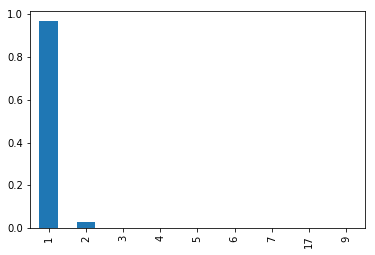

In [4]:
times_bought.value_counts(normalize=True).plot.bar()

Como é possível observar com o gráfico, a grande maioria dos clientes compra apenas uma vez.

In [5]:
more_than_once = all_orders.loc[np.where(times_bought > 1)]
more_than_once.count()

Unnamed: 0                       2997
order_id                         2997
customer_unique_id               2997
customer_city                    2997
customer_state                   2997
order_approved_at                2992
order_purchase_timestamp         2997
order_estimated_delivery_date    2997
order_delivered_carrier_date     2953
order_delivered_customer_date    2917
dtype: int64

## Hipótese: a região dos consumidores afeta se eles voltam a comprar ou não

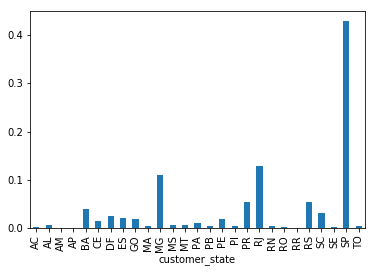

In [6]:
mto_by_state = more_than_once.groupby(['customer_state']).agg('count')['order_id']
(mto_by_state / more_than_once.count()[0]).plot.bar()

A maior parte dos clientes que volta é do estado de são paulo.

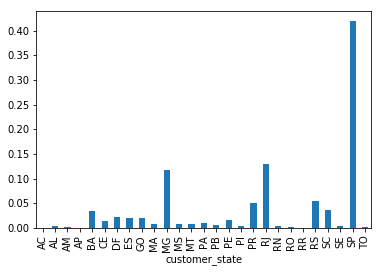

In [7]:
all_by_state = all_orders.groupby(['customer_state']).agg('count')['order_id']
(all_by_state / all_orders.count()[0]).plot.bar()

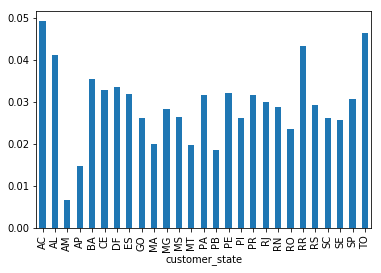

In [8]:
(mto_by_state / all_by_state).plot.bar()

In [9]:
pd.DataFrame({'mto': mto_by_state, 'all': all_by_state }).corr()['mto']['all']

0.9994653387646663

In [10]:
print(stats.kruskal(all_by_state / all_orders.count()[0], mto_by_state / more_than_once.count()[0]).pvalue * 100, '%', sep='')

88.30838631048043%


Fazendo uma análise da quantidade de clientes por estado, porém, percebe-se que a distribuição é quase exatamente a mesma. O P-Value para o teste de kruskal também é alto, indicando alta probabilidade de que a distribuição é idêntica.

É razoável assumir que o estado não tem nenhum tipo de efeito em se o cliente volta a comprar ou não.

## Hipótese: o atraso nas entregas afetam se as pessoas voltam ou não

In [11]:
def delivery_delay(order):
    estimated = pd.to_datetime(order['order_estimated_delivery_date'])
    delivered = pd.to_datetime(order['order_delivered_customer_date'])
    return delivered - estimated

In [12]:
delays_in_days_mto = delivery_delay(more_than_once) / np.timedelta64(24, 'h')
delays_in_days_all = delivery_delay(all_orders) / np.timedelta64(24, 'h')

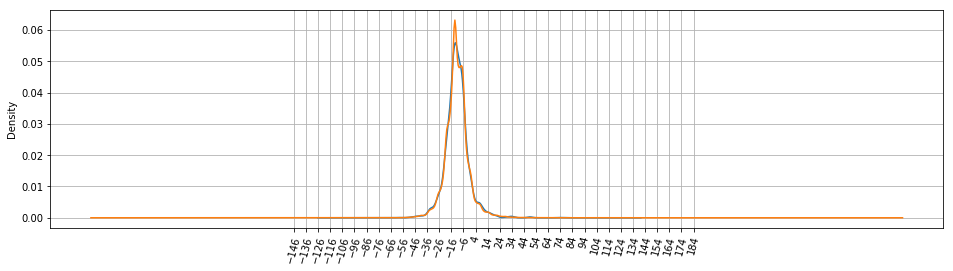

In [13]:
delays_in_days_mto.plot.kde(
    figsize=(16, 4),
    xticks=range(int(delays_in_days_mto.min()),
                 int(delays_in_days_mto.max()),
                 10),
    rot=75,
    grid=True)

delays_in_days_all.plot.kde(
    figsize=(16, 4),
    xticks=range(int(delays_in_days_all.min()),
                 int(delays_in_days_all.max()),
                 10),
    rot=75,
    grid=True)

In [14]:
ddmto = delays_in_days_mto.dropna().map(lambda x:math.trunc(x)).value_counts(normalize=True).sort_index()
ddmto.describe()

count    82.000000
mean      0.012195
std       0.018102
min       0.000343
25%       0.000686
50%       0.003085
75%       0.015598
max       0.071992
dtype: float64

In [15]:
ddall = delays_in_days_all.dropna().map(lambda x:math.trunc(x)).value_counts(normalize=True)[ddmto.index].sort_index()
ddall.describe()

count    82.000000
mean      0.012111
std       0.017925
min       0.000021
25%       0.000697
50%       0.002679
75%       0.017473
max       0.073863
dtype: float64

In [16]:
stats.kruskal(ddmto.values, ddall.values).pvalue

0.6759162116277826

A maioria das entregas para clientes que voltam acontecem dentro do prazo estipulado, e em sua maior parte adiantadas, com o pico no KDE no valor de -12 dias de "atraso", ou seja, 12 dias adiantado.

Para o total das entregas, no entanto, observa-se o mesmo padrão. Simultaneamente, o teste de Kruskal-Wallis apresenta um elevado p-value de 68%, o que indica que há uma boa chance de que as datas previstas e as datas de entrega apresentem a mesma distribuição tanto para a primeira compra quanto para os retornos. É possível que as entregas adiantadas não sejam a causa da volta dos clientes para mais compras.

## Hipótese: algumas categorias de produto apresentam maior taxa de reincidência do que outras

In [17]:
products = pd.read_csv('../datasets/trusted/sold_products.csv')
products.count()

Unnamed: 0                       104881
product_id                       104881
order_id                         104881
price                            104881
freight_value                    104881
order_purchase_timestamp         104881
order_estimated_delivery_date    104881
order_delivered_carrier_date     104881
order_delivered_customer_date    104881
product_category_name            104881
product_name_lenght              104881
product_description_lenght       104881
product_photos_qty               104881
product_weight_g                 104881
product_length_cm                104881
product_height_cm                104881
product_width_cm                 104881
dtype: int64

In [63]:
orders_by_category = pd.DataFrame({
    'id': all_orders['customer_unique_id'],
    'order_id': products['order_id'],
    'category': products['product_category_name']
}).dropna()
orders_by_category.count()

id          99441
order_id    99441
category    99441
dtype: int64

In [64]:
orders_by_category.groupby('id').agg('count')['order_id'].sort_values(ascending=False).head()

id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
6469f99c1f9dfae7733b25662e7f1782     7
ca77025e7201e3b30c44b472ff346268     7
Name: order_id, dtype: int64

In [65]:
categories = products['product_category_name'].unique()
print(''.join(map(lambda c: c.ljust(60), categories)))

cool_stuff                                                  pet_shop                                                    moveis_decoracao                                            perfumaria                                                  ferramentas_jardim                                          utilidades_domesticas                                       telefonia                                                   beleza_saude                                                livros_tecnicos                                             fashion_bolsas_e_acessorios                                 cama_mesa_banho                                             esporte_lazer                                               consoles_games                                              moveis_escritorio                                           malas_acessorios                                            alimentos                                                   agro_industria_e_comercio               

In [66]:
customers_by_category = pd.DataFrame([[customer for customer in orders_by_category[orders_by_category['category'] == category]['id']] for category in categories]).T
customers_by_category.columns = categories
customers_by_category.head()

,cool_stuff,pet_shop,moveis_decoracao,perfumaria,ferramentas_jardim,utilidades_domesticas,telefonia,beleza_saude,livros_tecnicos,fashion_bolsas_e_acessorios,...,cds_dvds_musicais,moveis_colchao_e_estofado,tablets_impressao_imagem,construcao_ferramentas_ferramentas,artes_e_artesanato,fashion_esporte,la_cuisine,pc_gamer,seguros_e_servicos,fashion_roupa_infanto_juvenil
0,7c396fd4830fd04220f754e42b4e5bff,299905e3934e9e181bfb2e164dd4b4f8,f2a85dec752b8517b5e58a06ff3cd937,e2dfa3127fedbbca9707b36304996dab,ccafc1c3f270410521c3c6f3b249870f,576ea0cab426cd8a00fad9a9c90a4494,a6fefcd9f434474cf6fcd8ed1102fd63,6cbe8a392b76916e84c2faf69d0d0da0,661a5e18a28b34880ccc60112f2b8e8e,b6aa1d5781553afaa244c3e42246d93c,...,4ea6c3c0ddbe4935ab5766001f06c9e4,53fcfee1fcc02d39a932f8eed8d6d9b8,bee9356eb7c026e686722938b679471d,bfbad637ec59b54146a553e6ef427ea4,5fbfdca262348db58bdfae6bb33b18d3,9a9c99d9935776de5535985e829bace5,37f9711adee5be5ffdff5b728b8eb529,56b2d85788f3b0a6bb69d618a5684e1a,e8a398ff29ecd32cd95796a2fe0de274,cbafa8227623af5855f89a9e49210ef4
1,af07308b275d755c9edb36a90c618231,e49b5376d3eb639d5dc6e2851a2e73a1,782987b81c92239d922aa49d6bd4200b,04cf8185c71090d28baa4407b2e6d600,6e26bbeaa107ec34112c64e1ee31c0f5,f4a7ef6bd931f83d75d83b71c94e90df,37363700139c1aef873bbcd916e57dfd,92fd8aa5948e20c43a014c44c025c5e1,f1f4f45c8602d0db1329eed1c8e935d4,4a8c8f751984985cd49f74249da95aae,...,2b02fbae01181dfb18934ebfea46a89e,26824609b6ffd112ba3cff92fee70c0a,6513e63443ad3306789b25a8d0c864ce,f041d0ca4717eab95d05b412e6aaea17,d2f9fdfb4e3b99ad3e7a41588bd942d2,26eeafb746fcaa7f640aad03a1410fa5,bb3d6a451634de7b6d913793e4f7520c,4462b054b8d56ce4cc289435843d38cc,43ba4c5bac7ad4720dadce76a197a830,03d01a4b09e221a1bb37343eb990dbda
2,3a653a41f6f9fc3d2a113cf8398680e8,73da78eda27f160f2ed111e2916d162d,e97109680b052ee858d93a539597bba7,bf004b2b614c68e6d2401afc33741b33,6087cfc70fd833cf2db637a5e6e9d76b,bd13608b9c6033892ce62269b50a0afc,a2649503b92028291f011a976619b322,1b542f810484d8c042aed33a7c61a218,5f7d7732b351ce851a158528581af05f,00b2ca23369b68c4d4105ecea9c0cb93,...,ffbf790cac0b6cf2e411d9f158c0fbe2,fafbc4ecb15933633821dfd530c9263b,bba38923aa817f25c6dec24021ae3f09,9b6aaab71723727ac6a05977b6872876,b680711d9a869502a6966a7892ab97cc,aaf1073f5e24306f7d20f63e5804825f,9c28a565adee8c7bc1852b1278fb18c4,ac2245a91f23c10b0337a64ef66ace3a,None,abb9723eb9abc628514b570baf005c8e
3,7c142cf63193a1473d2e66489a9ae977,21ac2a805b374c2aa44d6a5301a1b4a9,1c4ad540c8c5c36be4a8b8ec08f79638,f3d96550a8adeb771fe53948521cf602,d0ff1a7468fcc46b8fc658ab35d2a12c,1428917cd397d4f9ac0fde76dd6f2266,c28b695680373781f8ff086844f72ef2,c796780c7daeab9e94cc052b1f103b21,92b0c5698b3008fd30c5230b2504df71,8b8028d453a01986b48c4271cc341475,...,c68c8c2217bb842d2dab9331ae200f07,776581cf5627bc9a3730f69f9a307476,00df047af693b421c167e27932bfd6c5,6eb44ebe2e1ab11ad3bfa6c8a1652e2c,2407d70d5ed17f1a306676228d34d846,8a1dd3dc626d8344f8907c542cd9b382,93311e88a2a2c4fbc066fc30870f5e46,a6cc2b0e951069e78ca04b7c5d68d8af,None,c926874a1718e1659db15d81e492b651
4,72632f0f9dd73dfee390c9b22eb56dd6,e2a39e986034a5b5dfd3df5b949fa618,00ac9cd5c4ad19e16e7c6f6864711737,b512b0686fca0440147aa0709672cd9b,634f09f6075fe9032e6c19609ffe995a,1974875b4a1d2e2ee6d586e3ba4d7602,6d47c2341b395b7e0294d8692016f6de,3e4fd73f1e86b135b9b121d6abbe9597,379222d9312a6f61a9b401c289cac564,939ca75cff8baa5ad59c798097fdc81a,...,da122df9eeddfedc1dc1f5349a1a690c,38a20b7e29a945b4904ad3b0fbedd593,ff22de821fd449e50e82f657090da1df,2d8ee45e74454f6c8cc717d84be94975,255895b4ce5caa5cd2fe0ed1f9fe2a8a,f794c59a46dc4872d97d173c1b51525a,0bb89e7e4324fc0c63a27ab1e165fa0b,468a27d5bd094619430a55dcddc7eac4,None,None


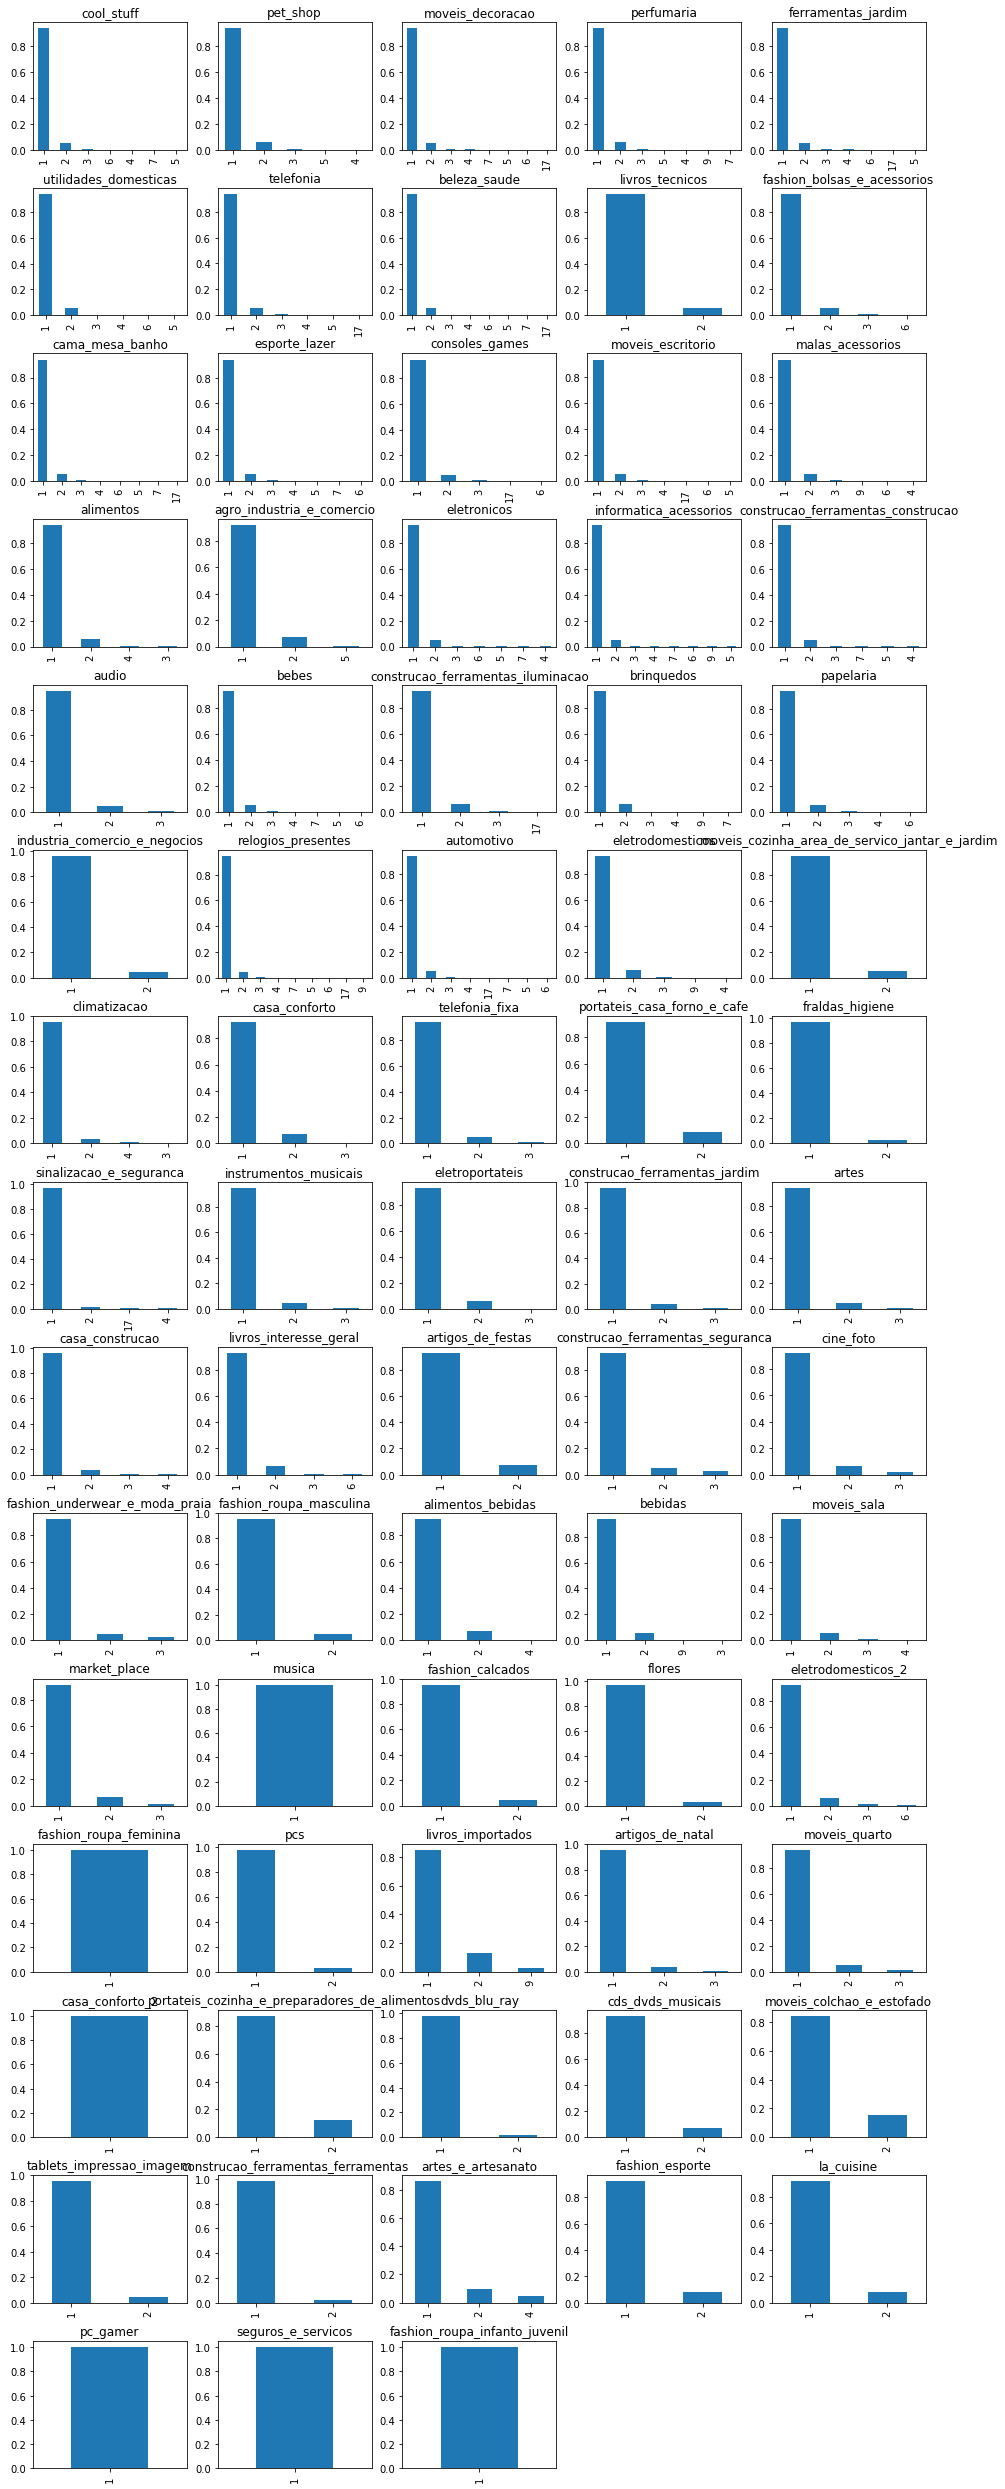

In [67]:
plt.figure(figsize=(16, 45))
plt.tight_layout()
plt.subplots_adjust(hspace=.3)

recurrence_by_category = pd.DataFrame(columns=['category', 'rate'])

for c in range(len(categories)):
    plt.subplot(15, 5, c + 1)
    customers = customers_by_category[categories[c]]
    orders_by_customers = all_orders[all_orders['customer_unique_id'].isin(customers.values)]
    sales_by_category = orders_by_customers.groupby(['customer_unique_id']).agg('count')['order_id'].sort_values(ascending=False)
    recurrence_by_category.loc[categories[c]] = [categories[c], sales_by_category[sales_by_category.values > 2].count() / sales_by_category.count()]
    
    plt.title(categories[c])
    sales_by_category.value_counts(normalize=True).plot.bar()
    #print(sales_by_category.head())
    
plt.show()

In [68]:
recurrence_by_category.sort_values(by='rate', ascending=False).head()

,category,rate
artes_e_artesanato,artes_e_artesanato,0.047619
construcao_ferramentas_seguranca,construcao_ferramentas_seguranca,0.025000
fashion_underwear_e_moda_praia,fashion_underwear_e_moda_praia,0.024590
livros_importados,livros_importados,0.021739
eletrodomesticos_2,eletrodomesticos_2,0.019231


In [84]:
recurrence_distribution = recurrence_by_category['rate'] / recurrence_by_category['rate'].sum()

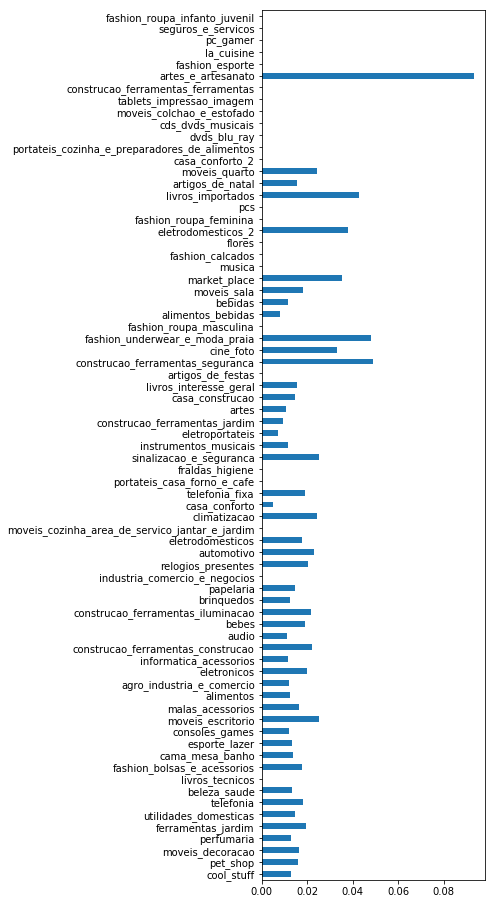

In [85]:
recurrence_distribution.plot.barh(figsize=(4, 16))

In [70]:
print(recurrence_by_category['rate'].std() / recurrence_by_category['rate'].mean() * 100, '%', sep='')

111.33876279614586%


(Não tenho muita certeza aqui, socorro 'u' @Pochete @Gabi @Gago)

Visto que o desvio padrão é alto, parece que, realmente, algumas categorias têm mais recorrência que outras.

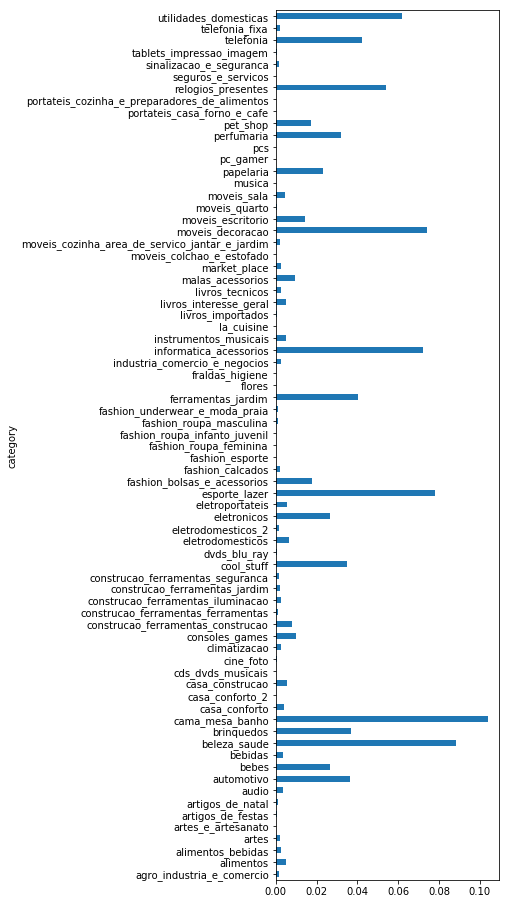

In [86]:
sales_by_category = orders_by_category.groupby('category').agg('count')['id']
sales_distribution = sales_by_category / sales_by_category.sum()
sales_distribution.plot.barh(figsize=(4, 16))

In [87]:
print(stats.kruskal(recurrence_distribution, sales_distribution).pvalue * 100, '%', sep='')

68.4749066151968%


O p-value de 68% encontrado para o teste de kruskal entre as duas distribuições indica que é possível, no entanto, que a taxa de recorrência nas compras para certas categorias seja mais elevada porque as compras nessas categorias são mais frequentes no geral.

Um maior volume de dados e uma janela de tempo mais abrangente ajudariam a dar respostas mais conclusivas nesse aspecto.